In [2]:
import torch
import numpy as np
import os
os.sys.path.append('../')
from rotm2euler import *
from experiment_utils import *
import cv2
import matplotlib.pyplot as plt
import pdb

## Input Data

In [3]:
### get pair id
pair_path = '/viscompfs/users/sawang/ScanNet/pair_list.txt'
f = open(pair_path)
lines = f.readlines()
lines[9995:10000]

['scene0001_01 1190-1200-1213 \n',
 'scene0001_01 1190-1201-1211 \n',
 'scene0001_01 1190-1202-1212 \n',
 'scene0001_01 1190-1203-1217 \n',
 'scene0001_01 1192-1204-1217 \n']

In [4]:
def input_data(tgt_id, src0_id, src1_id, dataset_dir, gt_dir, H, W):
    data_dict = dict()
    image = cv2.imread(os.path.join(dataset_dir, scene, 'color', str(tgt_id) + ".jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ori_H, ori_W, _ = image.shape
    image = cv2.resize(image, (320, 240))
    data_dict['tgt_RGB'] = image

    image = cv2.imread(os.path.join(dataset_dir, scene, 'color', str(src0_id) + ".jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240))
    data_dict['src0_RGB'] = image

    image = cv2.imread(os.path.join(dataset_dir, scene, 'color', str(src1_id) + ".jpg"))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240))
    data_dict['src1_RGB'] = image

    image = cv2.imread(os.path.join(gt_dir, scene, 'depth_interp', str(tgt_id) + ".png"), cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (320, 240))
    data_dict['depth'] = image / 1000

    #image = cv2.imread(os.path.join('/viscompfs/users/sawang/testnormal_2.png'), cv2.IMREAD_UNCHANGED)
    #image = cv2.resize(image, (320, 240)) / 255
    #image = unplot_normal(image)
    #data_dict['tgt_norm'] = image
    image = cv2.imread(os.path.join('/viscompfs/users/sawang/normal_sample/testnormal_2.png'), cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240)) / 255
    image = unplot_normal(image)
    data_dict['tgt_norm'] = image

    image = cv2.imread(os.path.join('/viscompfs/users/sawang/normal_sample/testnormal_1.png'), cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240)) / 255
    image = unplot_normal(image)
    data_dict['src0_norm'] = image

    image = cv2.imread(os.path.join('/viscompfs/users/sawang/normal_sample/testnormal_3.png'), cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (320, 240)) / 255
    image = unplot_normal(image)
    data_dict['src1_norm'] = image

    mat = np.loadtxt(os.path.join(dataset_dir, scene, 'intrinsic', 'intrinsic_color.txt'))
    scale_x, scale_y = H / ori_H, W / ori_W
    mat[0, 0], mat[0, 2] = mat[0, 0] * scale_x, mat[0, 2] * scale_x
    mat[1, 1], mat[1, 2] = mat[1, 1] * scale_y, mat[1, 2] * scale_y
    data_dict['K'] = mat
    print("intrinsic: \n", mat)

    mat = np.loadtxt(os.path.join(dataset_dir, scene, 'intrinsic', 'intrinsic_depth.txt'))
    scale_x, scale_y = H / ori_H, W / ori_W
    mat[0, 0], mat[0, 2] = mat[0, 0] * scale_x, mat[0, 2] * scale_x
    mat[1, 1], mat[1, 2] = mat[1, 1] * scale_y, mat[1, 2] * scale_y
    data_dict['K_d'] = mat
    print("intrinsic (depth): \n", mat)

    pose_path = '/viscompfs/users/sawang/ScanNet/data_pose/' + scene + '.txt'
    f = open(pose_path)
    pose_all = f.readlines()

    for p in pose_all:
        char = p.split(" ")
        if char[0] == str(tgt_id) and char[1] == str(src1_id):
            data_dict['pose1'] = untransform(np.array([float(c.replace(",", "")) for c in char[2:]]))
            print("pose1: \n", data_dict['pose1'])
        elif char[0] == str(src0_id) and char[1] == str(tgt_id):
            tmp = np.array([float(c.replace(",", "")) for c in char[2:]])
            tmp = untransform(tmp)
            pose_inv = inversePose(tmp)
            data_dict['pose0'] = pose_inv
            print("pose0: \n", data_dict['pose0'])
    return data_dict

In [5]:
tgt_id, src0_id, src1_id = 1200, 1190, 1213
H, W = 240, 320
scene = 'scene0001_01'
dataset_dir = '/viscompfs/users/sawang/ScanNet/data/scans/'
gt_dir = '/viscompfs/users/sawang/ScanNet/data_gt/'

data = input_data(tgt_id, src0_id, src1_id, dataset_dir, gt_dir, H, W)

intrinsic: 
 [[290.12925322   0.         160.59917355   0.        ]
 [  0.         288.93530568 119.44444444   0.        ]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]
intrinsic (depth): 
 [[143.27370372   0.          79.21487603   0.        ]
 [  0.         142.6841      59.13580247   0.        ]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]
pose0: 
 [[ 0.99720706 -0.01383514 -0.07339395  0.02787871]
 [ 0.00892915  0.99772935 -0.06675639 -0.09059185]
 [ 0.07415088  0.06591459  0.99506629  0.13103101]
 [ 0.          0.          0.          1.        ]]
pose1: 
 [[ 0.99900703 -0.03768448 -0.0237662   0.050552  ]
 [ 0.03849179  0.99866389  0.03447915  0.089673  ]
 [ 0.02243512 -0.03535972  0.99912279 -0.182378  ]
 [ 0.          0.          0.          1.        ]]


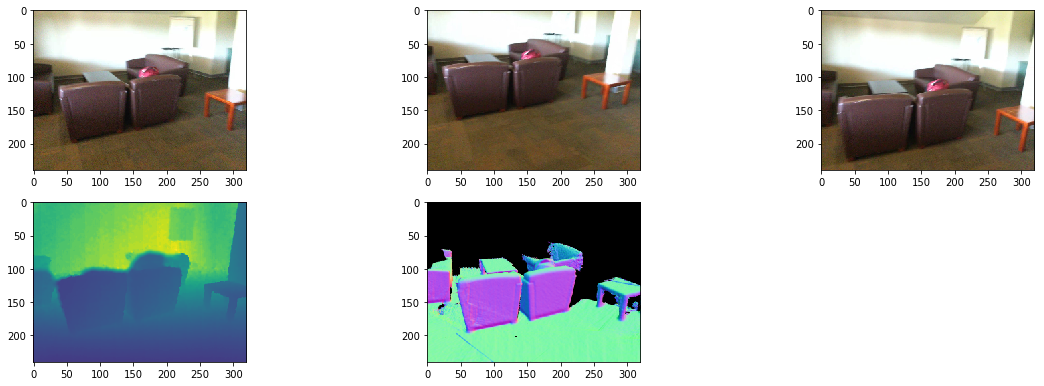

In [6]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(3, 3, 1)
ax.imshow(data['tgt_RGB'])
ax = fig.add_subplot(3, 3, 2)
ax.imshow(data['src0_RGB'])
ax = fig.add_subplot(3, 3, 3)
ax.imshow(data['src1_RGB'])
ax = fig.add_subplot(3, 3, 4)
ax.imshow(data['depth'])
ax = fig.add_subplot(3, 3, 5)
ax.imshow(plot_normal(data['tgt_norm']))

## Test `compute_cos_dist()`

In [70]:
def compute_cos_dist(pred_normal, cam_coords, alpha=0.1, n_shift=3):
    """Computes the depth and notmal orthogonality loss
        pred_normal: predicted normal of the network, [B, 3, H, W]
        cam_coords: Homogeneous 3D points of each pixel, [B, 4, H * W]
    """
    ## Remove Homogenous coord
    B, _, H, W = pred_normal.shape
    #pts_3d_map = cam_coords[:, :-1, :].view(B, 3, H, W)
    pts_3d_map = cam_coords

    nei = n_shift
    # shift the 3d pts map by nei along 8 directions
    pts_3d_map_ctr = pts_3d_map[:, :, nei:-nei, nei:-nei]
    pts_3d_map_x0 = pts_3d_map[:, :, nei:-nei, 0:-(2*nei)]
    pts_3d_map_y0 = pts_3d_map[:, :, 0:-(2*nei), nei:-nei]
    pts_3d_map_x1 = pts_3d_map[:, :, nei:-nei, 2*nei:]
    pts_3d_map_y1 = pts_3d_map[:, :, 2*nei:, nei:-nei]
    pts_3d_map_x0y0 = pts_3d_map[:, :, 0:-(2*nei), 0:-(2*nei)]
    pts_3d_map_x0y1 = pts_3d_map[:, :, 2*nei:, 0:-(2*nei)]
    pts_3d_map_x1y0 = pts_3d_map[:, :, 0:-(2*nei), 2*nei:]
    pts_3d_map_x1y1 = pts_3d_map[:, :, 2*nei:, 2*nei:]

    # generate difference between the central pixel and one of 8 neighboring pixels
    # each `diff` has shape [batch, 3, H-2*nei, W-2*nei]
    diff_x0 = pts_3d_map_ctr - pts_3d_map_x0
    diff_x1 = pts_3d_map_ctr - pts_3d_map_x1
    diff_y0 = pts_3d_map_y0 - pts_3d_map_ctr
    diff_y1 = pts_3d_map_y1 - pts_3d_map_ctr
    diff_x0y0 = pts_3d_map_x0y0 - pts_3d_map_ctr
    diff_x0y1 = pts_3d_map_ctr - pts_3d_map_x0y1
    diff_x1y0 = pts_3d_map_x1y0 - pts_3d_map_ctr
    diff_x1y1 = pts_3d_map_ctr - pts_3d_map_x1y1
    diff_stk = [diff_x0, diff_y0, diff_x1, diff_y1, diff_x0y0, diff_x0y1, diff_x1y0, diff_x1y1]

    
    # crop pred_norm
    cropped_norm = pred_normal[:, :, nei:-nei, nei:-nei]
    n_norm = torch.norm(cropped_norm, dim=1, keepdim=True)

    # calculate loss by dot product
    cos_dist_all = torch.zeros_like(n_norm)
    for diff in diff_stk:
        v_norm = torch.norm(diff, dim=1)
        cos_dist = torch.sum(diff * cropped_norm, 1, keepdim=True) / (v_norm * n_norm + 1e-10)
        cos_dist_abs = torch.abs(cos_dist)
        cos_dist_all = cos_dist_all + cos_dist_abs
    cos_dist_all = cos_dist_all / 8
    return cos_dist_all

In [71]:
def homogenize(pts):
    ones = np.ones_like(pts[:, :, 0])
    return np.dstack((pts, ones))

def check_compute_homography(data, depth, normal):
    H, W = 240, 320    
    meshgrid = np.dstack(np.meshgrid(range(W), range(H)))
    meshgrid = homogenize(meshgrid).reshape((-1, 3))
    meshgrid = np.transpose(meshgrid, (1, 0))
    K_inv = np.linalg.inv(data['K'][:3, :3])
    cam_coord = depth * (K_inv @ meshgrid)  ## (3, H * W)
    cam_coord = cam_coord.T.reshape((H, W, 3)).astype(np.float32).transpose((2, 0, 1))
    cam_coord_ten = torch.from_numpy(cam_coord[np.newaxis, :, :, :])
    
    normal = torch.from_numpy(normal[np.newaxis, :, :, :].astype(np.float32).transpose((0, 3, 1, 2)))
    
    cos_dis_all = compute_cos_dist(normal, cam_coord_ten, alpha=0.1, n_shift=3)
    cos_dis_all = cos_dis_all.numpy().squeeze()
    return cos_dis_all

### Test case #1

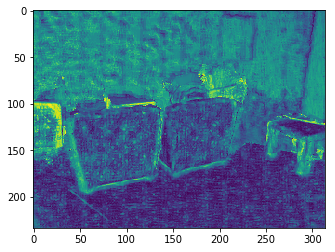

In [74]:
normal = data['tgt_norm']
cos_dis_all = check_compute_homography(data, data['depth'].reshape((1, -1)), normal)
plt.imshow(cos_dis_all)

### Test case #2

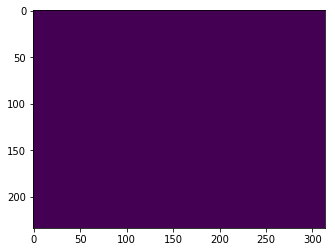

In [75]:
depth = np.ones_like(data['depth'].reshape((1, -1)))
normal = np.zeros_like(data['tgt_norm'])
normal[:, :, 2] = -1
cos_dis_all = check_compute_homography(data, depth, normal)
plt.imshow(cos_dis_all)